In [9]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set()

In [10]:
path_to_data = '../../data/00_raw/agriculture_prices.db'
conn = sqlite3.connect(path_to_data)
c = conn.cursor()

In [11]:
produce_df = pd.DataFrame(c.execute('''SELECT * FROM agriculture_prices''').fetchall())

In [12]:
produce_df.columns = ['Farm Price', 'Atlanta Retail', 'Chicago Retail', 'Los Angeles Retail', 'NYC Retail', 'Avg Spread', 'Commodity', 'Date']

In [13]:
produce_df.head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
0,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries,2019-05-19
1,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries,2019-05-12
2,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries,2019-05-05
3,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries,2019-04-28
4,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries,2019-04-21


In [14]:
produce_df.tail()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,Date
213791,0.28,1.69,0.0,1.24,1.19,267.86%,Nectarines,2000-07-23
213792,0.26,1.61,0.0,1.37,1.19,300.96%,Nectarines,2000-07-16
213793,0.30,1.71,0.0,1.42,1.19,260.00%,Nectarines,2000-07-09
213794,0.33,1.96,0.0,0.92,1.04,196.97%,Nectarines,2000-07-02
213795,0.39,1.22,0.0,0.92,1.19,113.46%,Nectarines,2000-06-25


In [15]:
produce_df.index = pd.to_datetime(produce_df['Date'])

In [16]:
produce_df.drop(columns=['Date'], inplace=True)

In [17]:
conn.close()

# Cleaning Data and Adding Features
Want to update all prices to reflect 2019 dollars (adjust for inflation), and will be taking an average for all retail prices. A dataframe with mean annual farm prices, mean annual average retail, standard deviations, and year as an index will be created.

Since this needs to be done by commodity, I am also going to make a dictionary that holds data frames by commodity, produce_dict. So for example, typing ``produce_dict['Strawberries']`` will return a dataframe concerning only strawberries.

In [18]:
produce_list = list(produce_df['Commodity'].unique())
produce_list

['Strawberries',
 'Romaine Lettuce',
 'Red Leaf Lettuce',
 'Potatoes',
 'Oranges',
 'Iceberg Lettuce',
 'Green Leaf Lettuce',
 'Celery',
 'Cauliflower',
 'Carrots',
 'Cantaloupe',
 'Broccoli Crowns',
 'Avocados',
 'Broccoli Bunches',
 'Asparagus',
 'Flame Grapes',
 'Thompson Grapes',
 'Honeydews',
 'Tomatoes',
 'Plums',
 'Peaches',
 'Nectarines']

In [19]:
produce_dict = dict()
for produce in produce_list:
    produce_dict.setdefault(produce, produce_df[produce_df['Commodity'] == produce])

In [20]:
produce_dict['Strawberries'].head()

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity
Date,,,,,,,
2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries
2019-05-12,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries
2019-05-05,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries
2019-04-28,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries
2019-04-21,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries


# Getting Variance 
Getting variance rather than standard deviation for the retail averages because I will need to find the standard deviation again when I take the yearly mean. Since the standard deviation then becomes the square root of the yearly mean of the variances, it is better to keep this step.

In [21]:
for item in produce_list:
    avg_retail = [np.mean(x[1:5]) for x in produce_dict[item].values]
    avg_retail_std = [np.var(x[1:5],ddof=1) for x in produce_dict[item].values] #sample standard deviation
    produce_dict.get(item).loc[:,'avg_retail'] = avg_retail
    produce_dict.get(item).loc[:,'avg_retail_var'] = avg_retail_std
    

/Users/timchristy/.local/share/virtualenvs/agriculture-price-analysis-wczIgwxP/lib/python3.8/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/timchristy/.local/share/virtualenvs/agriculture-price-analysis-wczIgwxP/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
produce_dict['Strawberries']

,Farm Price,Atlanta Retail,Chicago Retail,Los Angeles Retail,NYC Retail,Avg Spread,Commodity,avg_retail,avg_retail_var
Date,,,,,,,,,
2019-05-19,1.16,2.23,1.70,1.99,2.54,82.33%,Strawberries,2.1150,0.127233
2019-05-12,0.91,2.67,1.89,2.47,2.66,166.21%,Strawberries,2.4225,0.134492
2019-05-05,0.58,2.42,1.89,2.12,2.91,302.59%,Strawberries,2.3350,0.194033
2019-04-28,0.58,2.79,1.95,2.38,2.96,334.48%,Strawberries,2.5200,0.203667
2019-04-21,0.69,2.92,2.04,2.38,3.16,280.43%,Strawberries,2.6250,0.258500
...,...,...,...,...,...,...,...,...,...
1999-08-23,0.72,2.62,0.00,3.12,2.59,189.24%,Strawberries,2.0825,1.986558
1999-08-16,0.58,2.44,0.00,3.22,2.77,263.36%,Strawberries,2.1075,2.076225
1999-08-09,0.65,2.49,0.00,2.99,2.87,221.15%,Strawberries,2.0875,1.982158


# Dropping columns
Dropping unnecessary columns: Atlanta Retail, Chicago Retail, Los Angeles Retail, NYC Retail, Avg Spread, and Commodity (commodity is kept track via key in dictionary; produce_dict)

In [23]:
for item in produce_list:
    produce_dict.get(item).drop(columns=['Atlanta Retail', 'Chicago Retail', 'Los Angeles Retail', 'NYC Retail', 'Avg Spread', 'Commodity'], inplace=True)

/Users/timchristy/.local/share/virtualenvs/agriculture-price-analysis-wczIgwxP/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


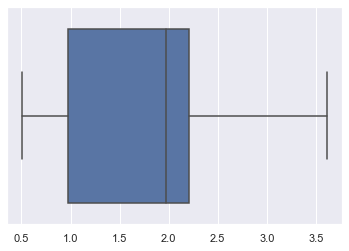

In [35]:
sns.boxplot(produce_dict['Strawberries'][produce_dict['Strawberries'].index.year == 1999])

# Now to take Annual Averages

In [25]:
produce_yearly_mean_dict = {}

In [18]:
for key, value in produce_dict.items():
    produce_yearly_mean_dict[key] = produce_dict[key].resample('Y').mean()
    produce_yearly_mean_dict[key].columns = ['Annual Mean Farm Price', 'Annual Mean Average Retail', 'annual_mean_avg_retail_var']
    produce_yearly_mean_dict[key]['annual_mean_farm_price_stdev'] = produce_dict[key]['Farm Price'].resample('Y').std()
    produce_yearly_mean_dict[key].index = produce_yearly_mean_dict[key].index.year
    produce_yearly_mean_dict[key]['annual_mean_avg_retail_std'] = np.sqrt(produce_yearly_mean_dict[key]['annual_mean_avg_retail_var'])
    produce_yearly_mean_dict[key].drop(columns=['annual_mean_avg_retail_var'], inplace=True)

In [19]:
produce_yearly_mean_dict['Oranges']

,Annual Mean Farm Price,Annual Mean Average Retail,annual_mean_farm_price_stdev,annual_mean_avg_retail_std
Date,,,,
1999,0.867907,2.171453,0.328275,1.539567
2000,0.543660,1.484884,0.407027,1.170201
2001,0.577964,1.914683,0.529019,0.508310
2002,0.652154,1.941311,0.694222,0.496595
2003,0.569522,1.969990,0.580861,0.402497
2004,0.554701,1.940588,0.646189,1.361087
2005,0.555775,1.934457,0.592234,0.587143
2006,0.667903,2.102812,0.620453,0.633589
2007,0.666008,2.083798,0.654253,0.731371


# Adjusting for Inflation
Need to adjust for inflation. The following data was gathered from [The Federal Reserve Bank of Minneapolis](https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-)


| Year |  CPI  | Annual % Change|
|------|-------|------|
| 1997 | 160.5 | 2.3% |
| 1998 | 163.0 | 1.6% |
| 1999 | 166.6 | 2.2% |
| 2000 | 172.2 | 3.4% |
| 2001 | 177.1 | 2.8% |
| 2002 | 179.9 | 1.6% |
| 2003 | 184.0 | 2.3% |
| 2004 | 188.9 | 2.7% |
| 2005 | 195.3 | 3.4% |
| 2006 | 201.6 | 3.2% |
| 2007 | 207.3 | 2.9% |
| 2008 | 215.3 | 3.8% |
| 2009 | 214.5 | -0.4%|
| 2010 | 218.1 | 1.6% |
| 2011 | 224.9 | 3.2% |
| 2012 | 229.6 | 2.1% |
| 2013 | 233.0 | 1.5% |
| 2014 | 236.7 | 1.6% |
| 2015 | 237.0 | 0.1% |
| 2016 | 240.0 | 1.3% |
| 2017 | 245.1 | 2.1% |
| 2018 | 251.1 | 2.4% |
| 2019*| 255.5 | 1.8% |

* 2019: It is still December 2019 as I write this. The average through November was calculated using the data from this website : [https://inflationdata.com/Inflation/Consumer_Price_Index/CurrentCPI.asp?reloaded=true](https://inflationdata.com/Inflation/Consumer_Price_Index/CurrentCPI.asp?reloaded=true) . 

This will be used to adjust prices to 2019 dollars

In [20]:
cpi = [166.6, 172.2, 177.1, 179.9, 184.0, 188.9, 195.3, 201.6, 207.3, 215.3, 214.5, 218.1, 224.9, 229.6, 233.0, 236.7, 237.0, 240.0, 245.1, 251.1, 255.5]

In [21]:
for item in produce_list:
    produce_yearly_mean_dict[item]['CPI'] = cpi

In [22]:
for item in produce_list:
    produce_yearly_mean_dict[item]['2019_farm_price'] = [(x[0]/x[-1])*255.5 for x in produce_yearly_mean_dict[item].values]
    produce_yearly_mean_dict[item]['2019_retail_price'] = [(x[1]/x[-2])*255.5 for x in produce_yearly_mean_dict[item].values]
    produce_yearly_mean_dict[item]['2019_farm_price_stdev'] = [(x[2]/x[-3])*255.5 for x in produce_yearly_mean_dict[item].values]
    produce_yearly_mean_dict[item]['2019_retail_stdev'] = [(x[3]/x[-4])*255.5 for x in produce_yearly_mean_dict[item].values]
    produce_yearly_mean_dict[item].drop(columns=['Annual Mean Farm Price', 'Annual Mean Average Retail', 'annual_mean_farm_price_stdev', 'annual_mean_avg_retail_std', 'CPI'], inplace=True)

In [23]:
produce_yearly_mean_dict['Strawberries'].head()

,2019_farm_price,2019_retail_price,2019_farm_price_stdev,2019_retail_stdev
Date,,,,
1999,1.229191,3.324491,0.404756,2.278873
2000,1.505322,2.897508,0.671750,2.034456
2001,1.893440,4.161362,0.693149,0.918771
2002,1.768529,4.164412,0.726291,0.559772
2003,1.977239,4.311494,0.978334,0.667823


# Strawberries

In [24]:
years = np.array(produce_yearly_mean_dict['Strawberries'].index)
farm_price = np.array(produce_yearly_mean_dict['Strawberries']['2019_farm_price'])
retail_price = np.array(produce_yearly_mean_dict['Strawberries']['2019_retail_price'])
farm_stdev = np.array(produce_yearly_mean_dict['Strawberries']['2019_farm_price_stdev'])
retail_stdev = np.array(produce_yearly_mean_dict['Strawberries']['2019_retail_stdev'])

In [25]:
len(farm_price)

21

In [42]:
years[0:11]

array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009])

In [43]:
farm_price[0:11]

array([1.22919118, 1.50532151, 1.8934397 , 1.76852881, 1.97723892,
       2.1321874 , 1.84847143, 1.87776361, 1.94665989, 1.86748053,
       1.61674646])

In [62]:
git('exploring histograms. CI is not correct')

[master a3081cf] fexploring histograms. CI is not correct
 1 file changed, 31 insertions(+), 2 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 4 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1011 bytes | 1011.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To github.com:tim-christy/agriculture-price-analysis.git
   ca9b5e5..a3081cf  master -> master


(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25]),
 <a list of 10 Text yticklabel objects>)

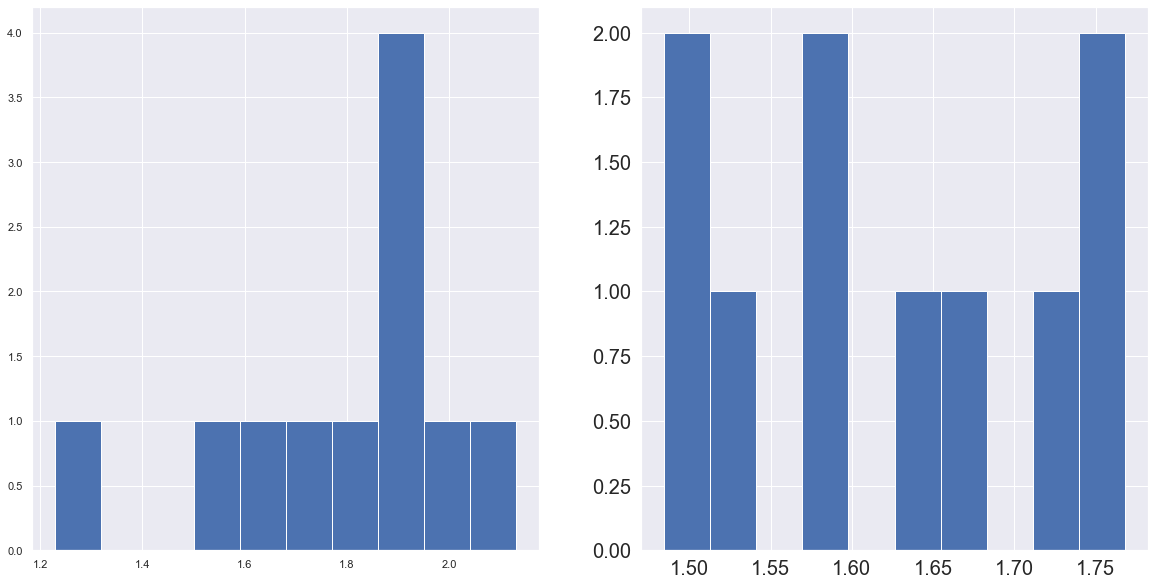

In [60]:
#Don't do it by decade. Try each year? Boxplots by year?

f = plt.figure(figsize=(20,10))
ax = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

ax.hist(farm_price[0:11])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax2.hist(farm_price[11:])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)



(array([1., 0., 1., 5., 3., 4., 1., 4., 1., 1.]),
 array([1.22919118, 1.3194908 , 1.40979042, 1.50009004, 1.59038967,
        1.68068929, 1.77098891, 1.86128853, 1.95158816, 2.04188778,
        2.1321874 ]),
 <a list of 10 Patch objects>)

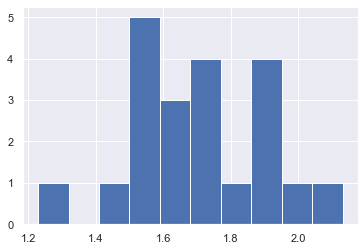

In [53]:
plt.figure()
plt.hist(farm_price)

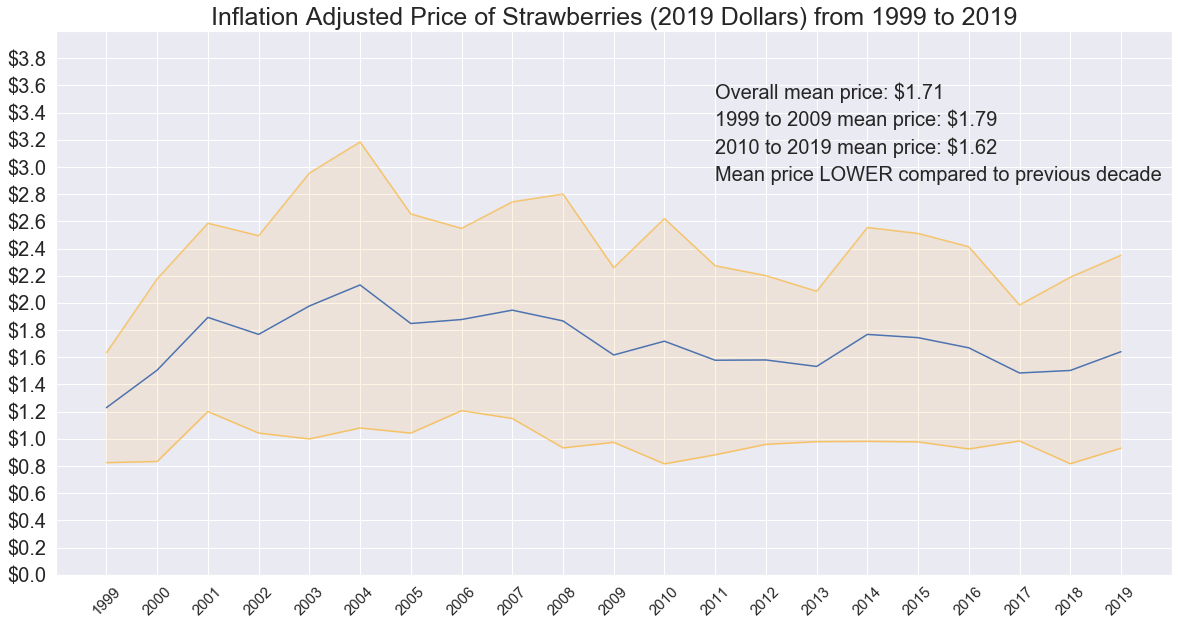

In [26]:
plt.figure(figsize=(20, 10))
x_label_pos = list(np.arange(1999, 2020))
names = [str(x) for x in np.arange(1999, 2020)]
plt.title(f'Inflation Adjusted Price of {produce_list[0]} (2019 Dollars) from 1999 to 2019', fontsize=25)
plt.xticks(x_label_pos, names, fontsize = 15, rotation=45 )
plt.ylim(0, 4)
plt.yticks([x for x in np.arange(0, 4, 0.2)], [ ('$'+str(round(x,3))) for x in np.arange(0, 4, 0.2)], fontsize=20)
plt.plot(years, farm_price)
plt.plot(years, (farm_price+farm_stdev), c='orange', alpha=0.5)
plt.plot(years, (farm_price-farm_stdev), c='orange', alpha=0.5)
plt.fill_between(years, farm_price-farm_stdev, farm_price+farm_stdev, color='orange', alpha=0.1)
plt.text(2011, 3.5, f'Overall mean price: ${round(np.mean(farm_price),2)}', fontsize=20)
plt.text(2011, 3.3, f'1999 to 2009 mean price: ${round(np.mean(farm_price[:11]),2)}', fontsize=20)
plt.text(2011, 3.1, f'2010 to 2019 mean price: ${round(np.mean(farm_price[11:]),2)}', fontsize=20)

first_decade = round(np.mean(farm_price[:11]),2)
second_decade = round(np.mean(farm_price[11:]),2)
if first_decade > second_decade:
    plt.text(2011, 2.9, 'Mean price LOWER compared to previous decade', fontsize=20)
    
elif first_decade < second_decade:
    plt.text(2011, 2.9, 'Mean price HIGHER compared to previous decade', fontsize=20)
    
else:
    plt.text(2011, 2.9, 'No change in mean price', fontsize=20)
    


In [39]:
def produce_plotter(produce_name):
    '''For a given produce name, this function searches the produce_yearly_mean_dict for the named 
       data frame, and plots the annual average retail price from 1999 to 2019 with 1 standard deviation
       plotted above and below. 
       
       Parameters: produce_name - name of produce of interest from the dictionary
       '''
    
    years = np.array(produce_yearly_mean_dict[f'{produce_name}'].index)
    farm_price = np.array(produce_yearly_mean_dict[f'{produce_name}']['2019_farm_price'])
    retail_price = np.array(produce_yearly_mean_dict[f'{produce_name}']['2019_retail_price'])
    farm_stdev = np.array(produce_yearly_mean_dict[f'{produce_name}']['2019_farm_price_stdev'])
    retail_stdev = np.array(produce_yearly_mean_dict[f'{produce_name}']['2019_retail_stdev'])
    
    
    plt.figure(figsize=(20, 10))
    x_label_pos = list(np.arange(1999, 2020))
    names = [str(x) for x in np.arange(1999, 2020)]
    plt.title(f'Inflation Adjusted Price of {produce_name} (2019 USD) from 1999 to 2019', fontsize=25)
    plt.xticks(x_label_pos, names, fontsize = 15, rotation=45 )
    plt.ylim(0, 4)
    plt.yticks([x for x in np.arange(0, 4, 0.2)], [ ('$'+str(round(x,3))) for x in np.arange(0, 4, 0.2)], fontsize=20)
    plt.plot(years, farm_price)
    plt.plot(years, (farm_price+farm_stdev), c='red', alpha=0.5)
    plt.plot(years, (farm_price-farm_stdev), c='red', alpha=0.5)
    plt.fill_between(years, farm_price-farm_stdev, farm_price+farm_stdev, color='red', alpha=0.1)
    
    plt.text(2011, 3.5, f'Overall mean price: ${round(np.mean(farm_price),2)}', fontsize=20)
    plt.text(2011, 3.3, f'1999 to 2009 mean price: ${round(np.mean(farm_price[:11]),2)}', fontsize=20)
    plt.text(2011, 3.1, f'2010 to 2019 mean price: ${round(np.mean(farm_price[11:]),2)}', fontsize=20)

    first_decade = round(np.mean(farm_price[:11]),2)
    second_decade = round(np.mean(farm_price[11:]),2)
    if first_decade > second_decade:
        plt.text(2011, 2.9, f'deltaP = {round(second_decade - first_decade, 2)}', fontsize=20)
        

    elif first_decade < second_decade:
        plt.text(2011, 2.9, f'deltaP = {round(second_decade - first_decade, 2)}', fontsize=20)

    else:
        plt.text(2011, 2.9, 'No change in mean price', fontsize=20)

<ipython-input-39-3b81f9072c6a>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 10))


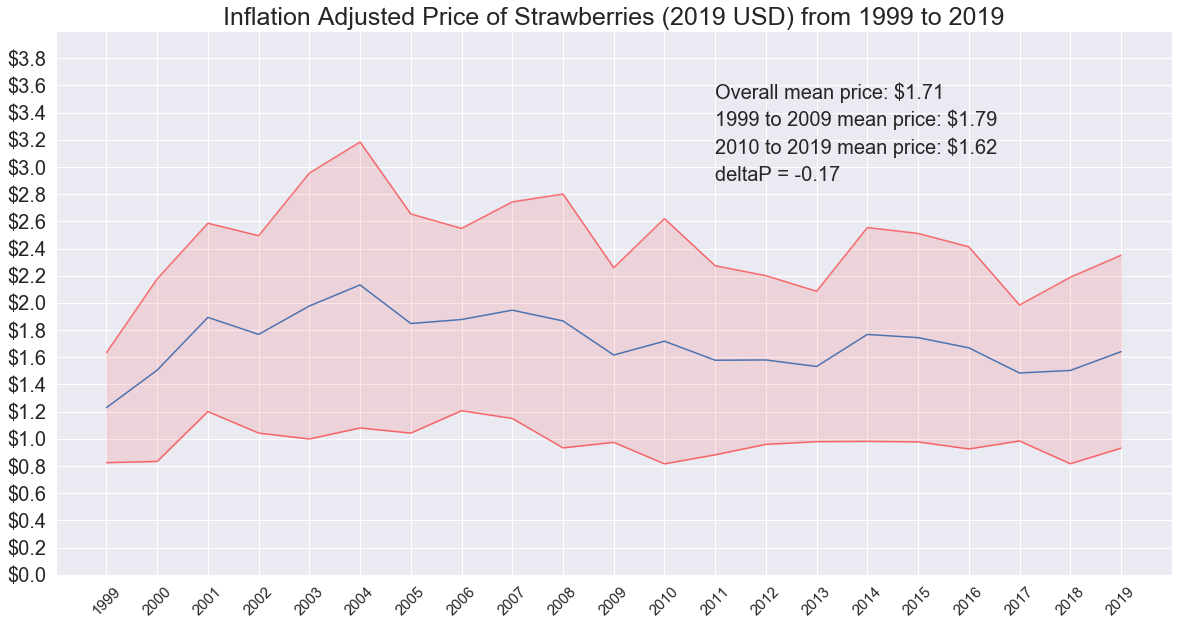

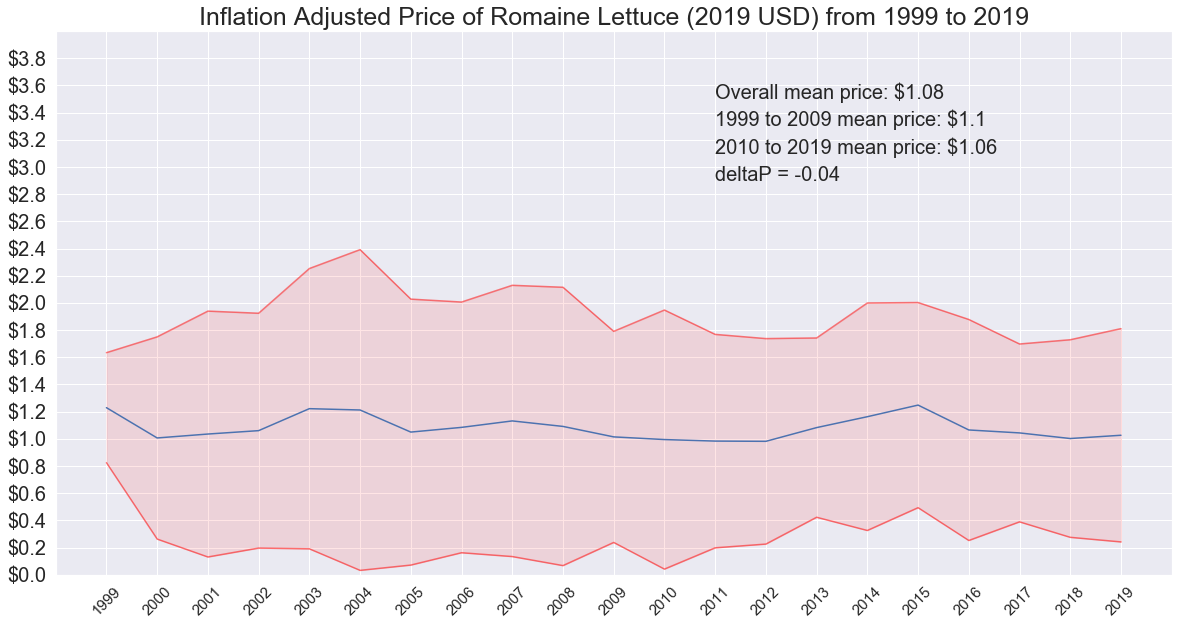

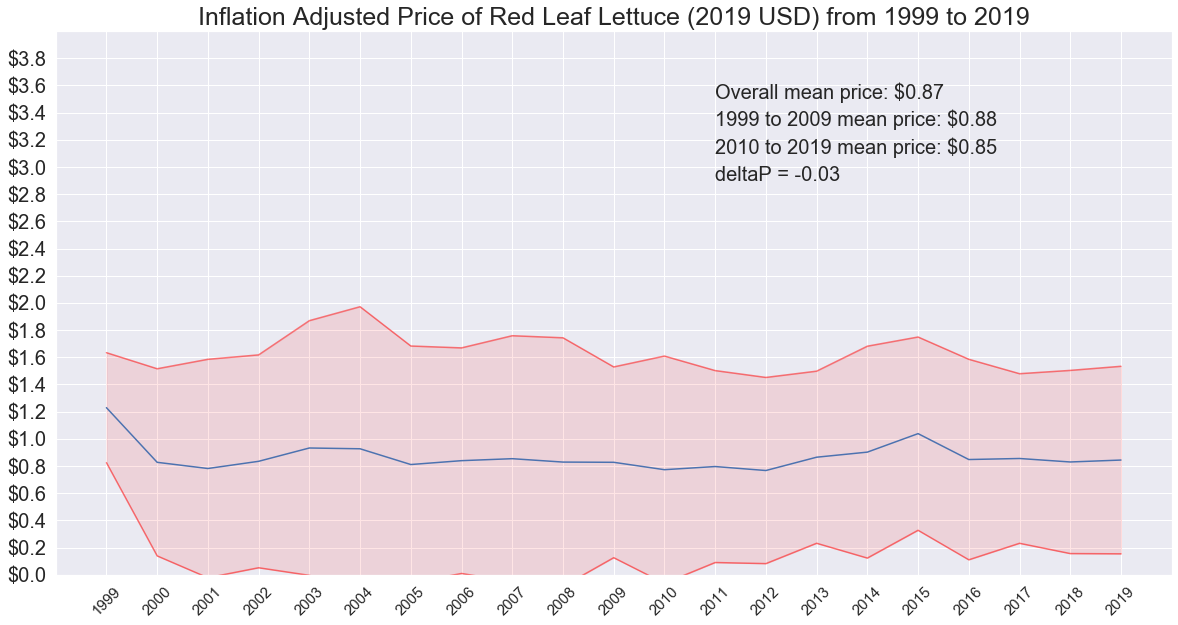

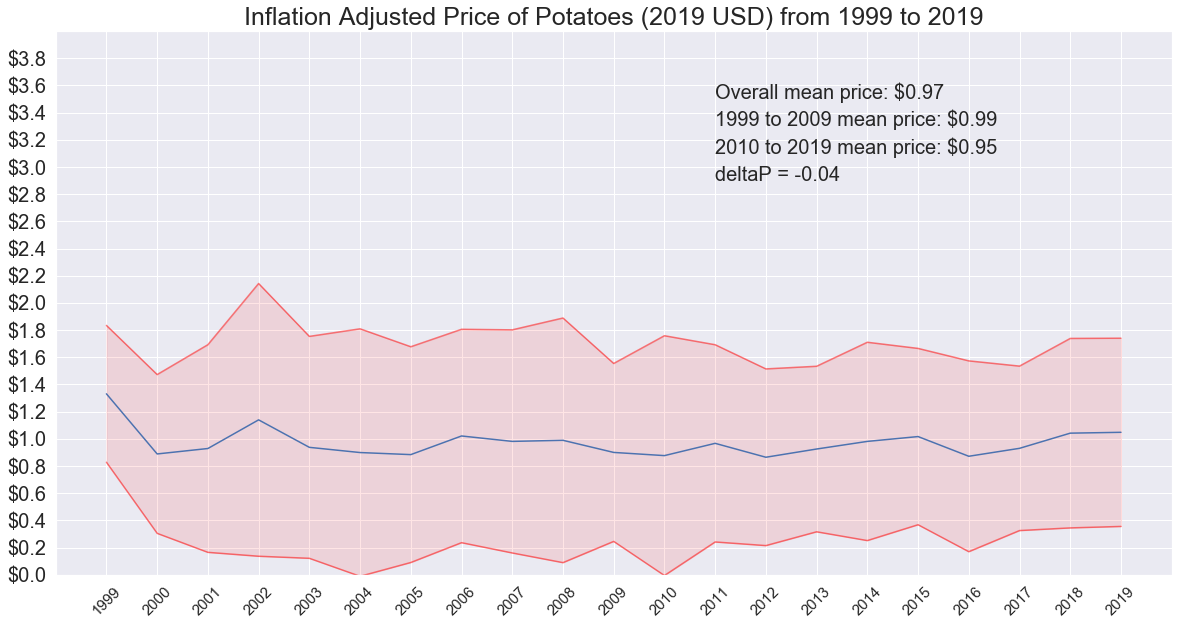

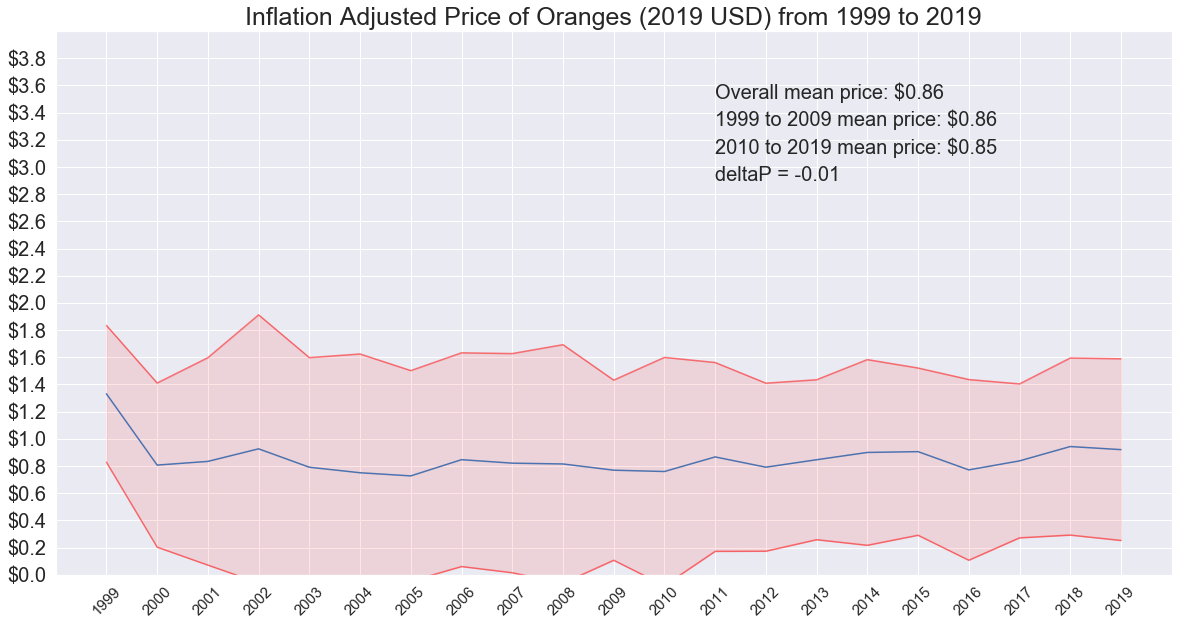

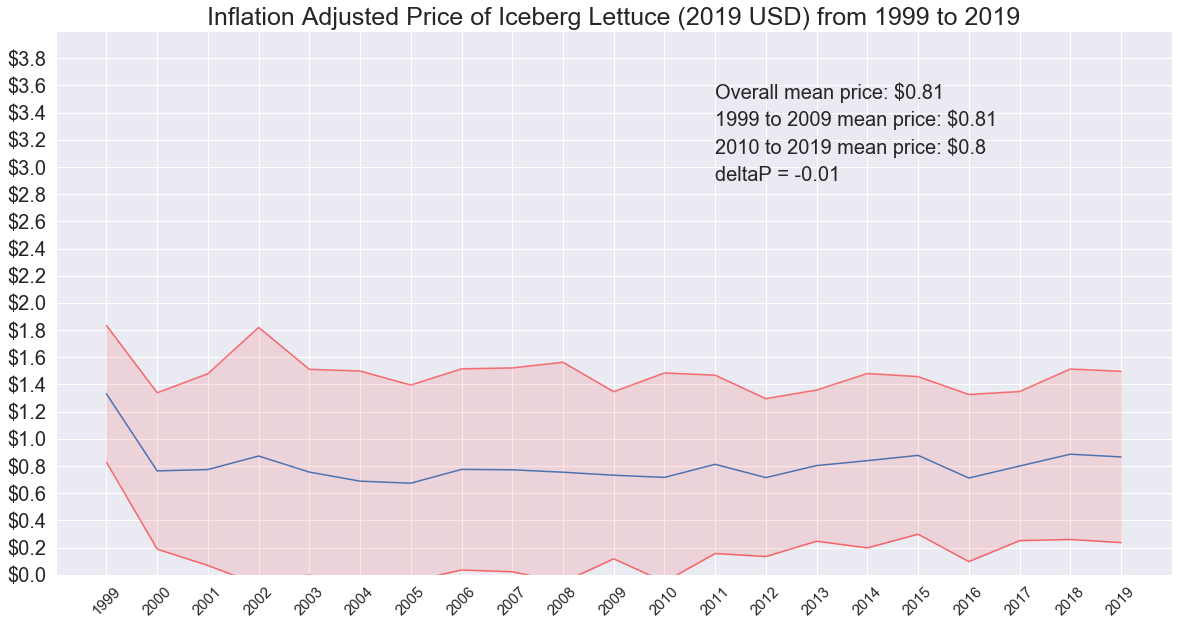

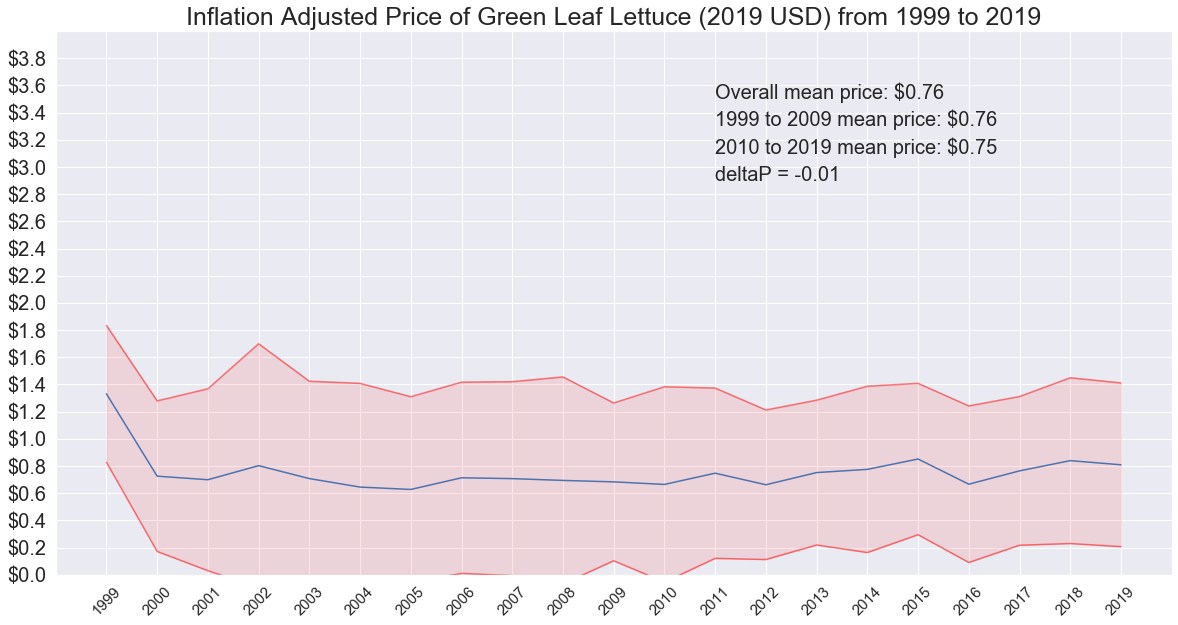

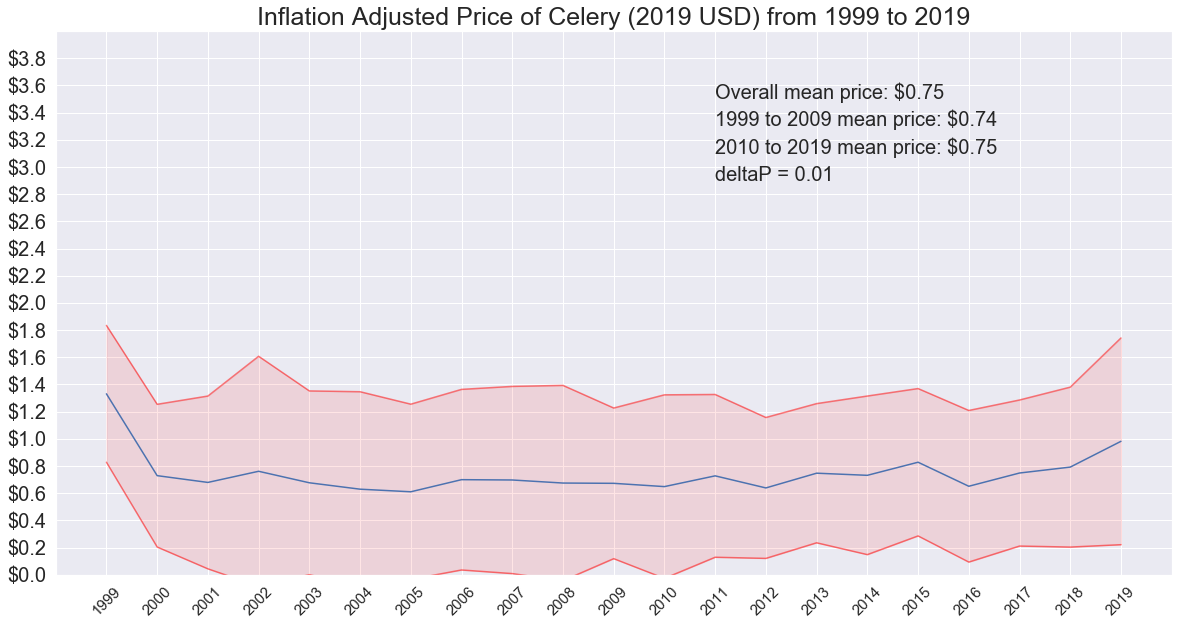

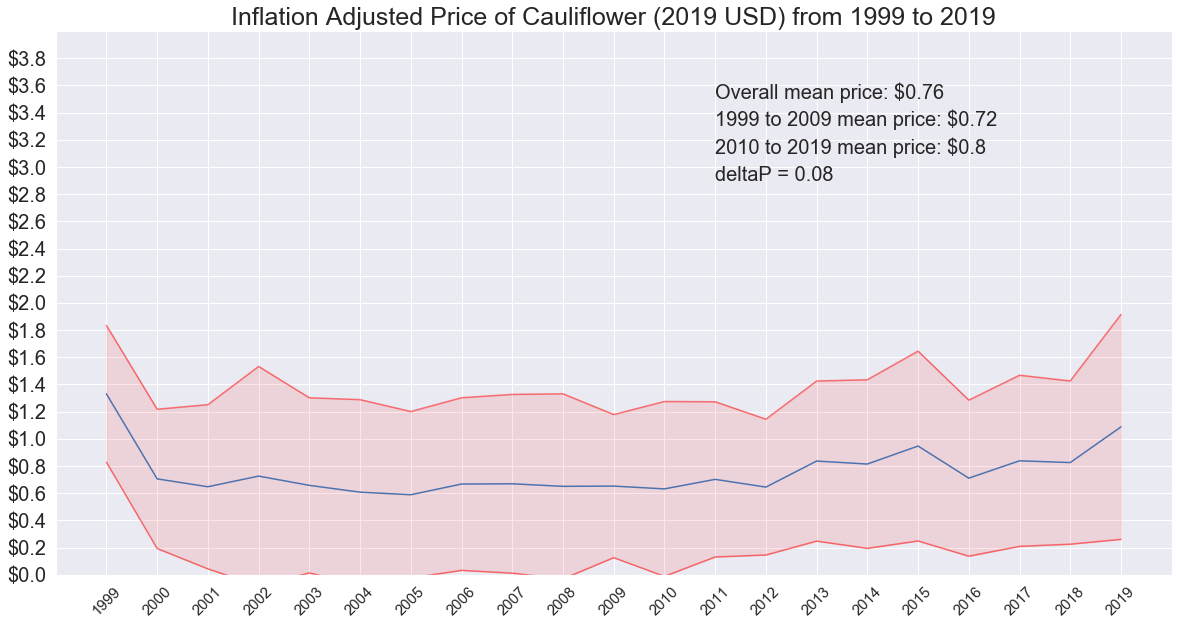

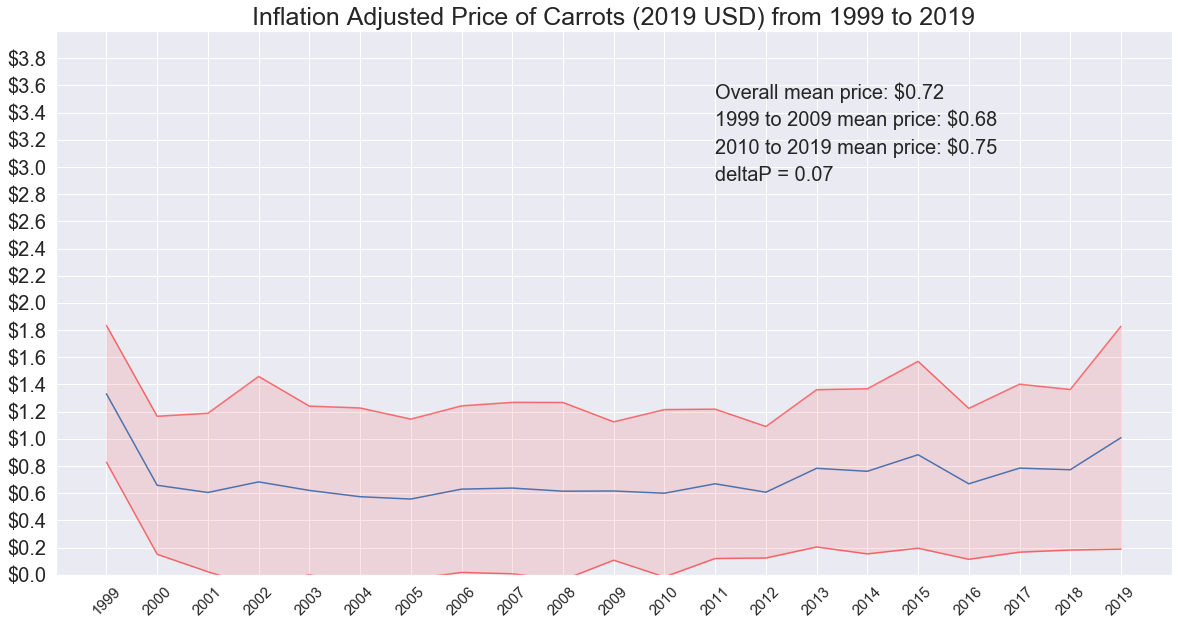

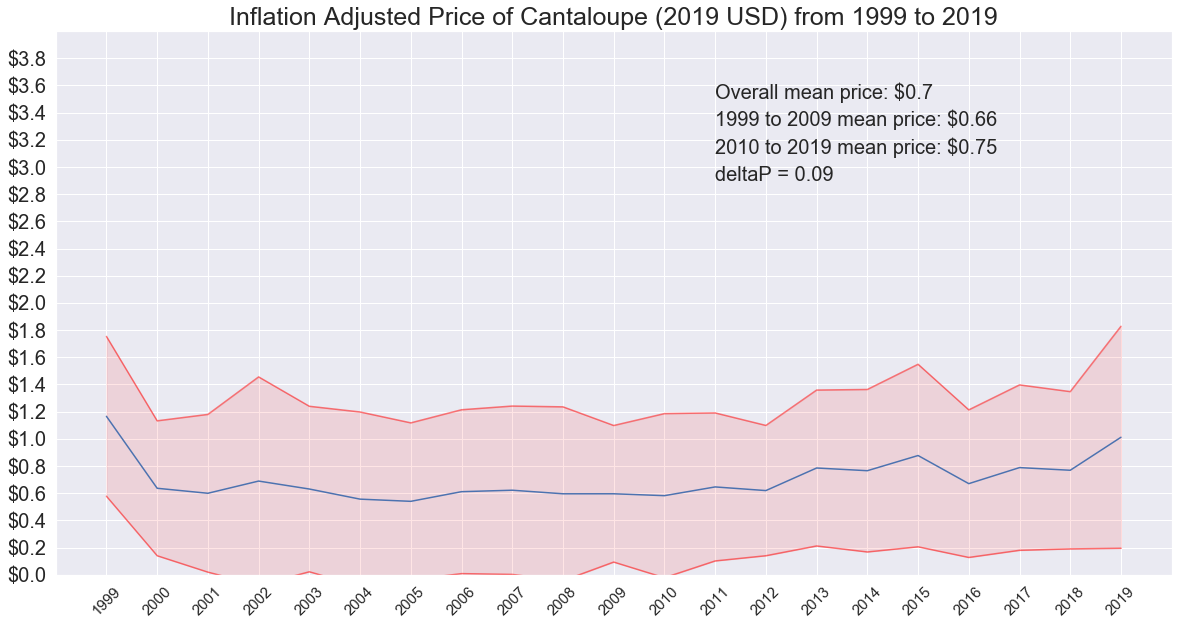

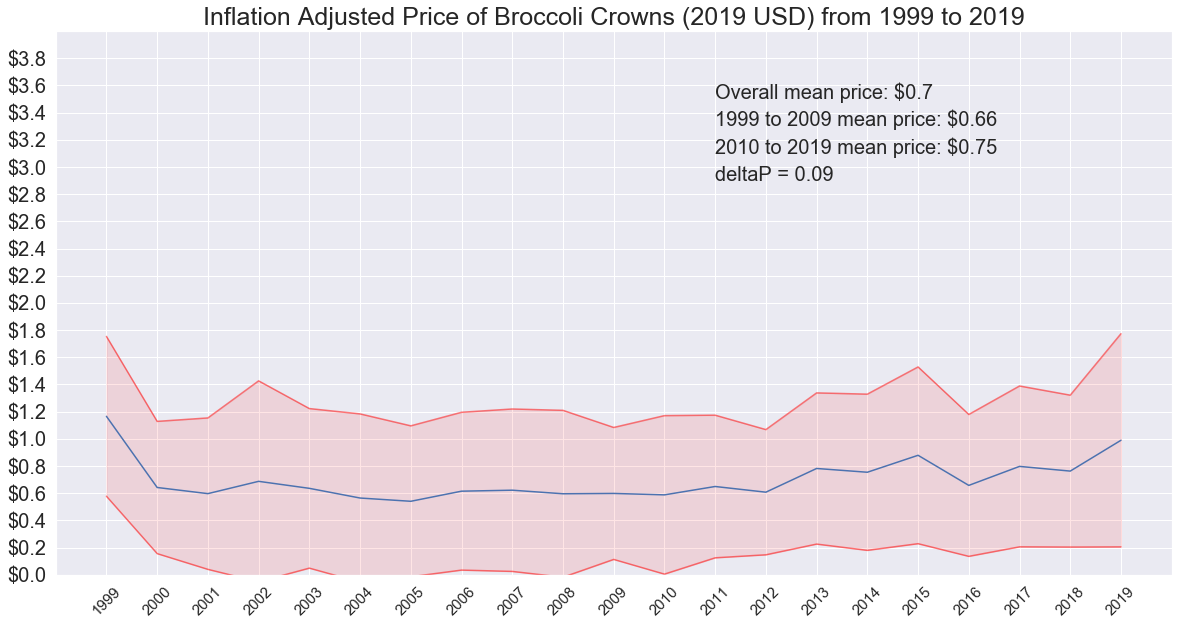

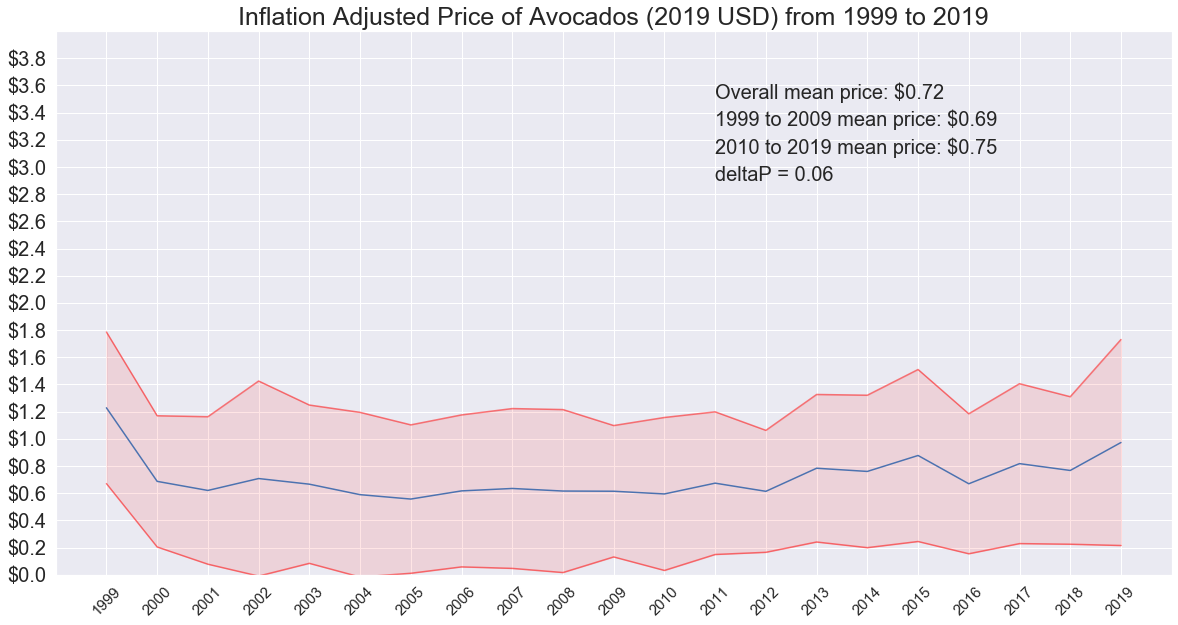

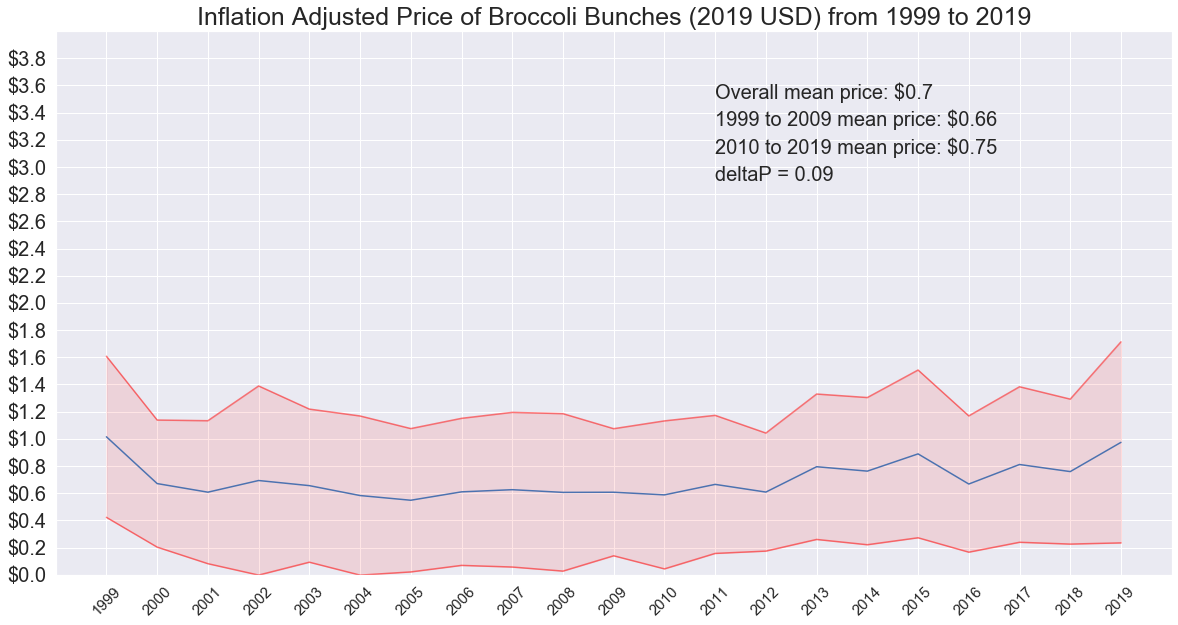

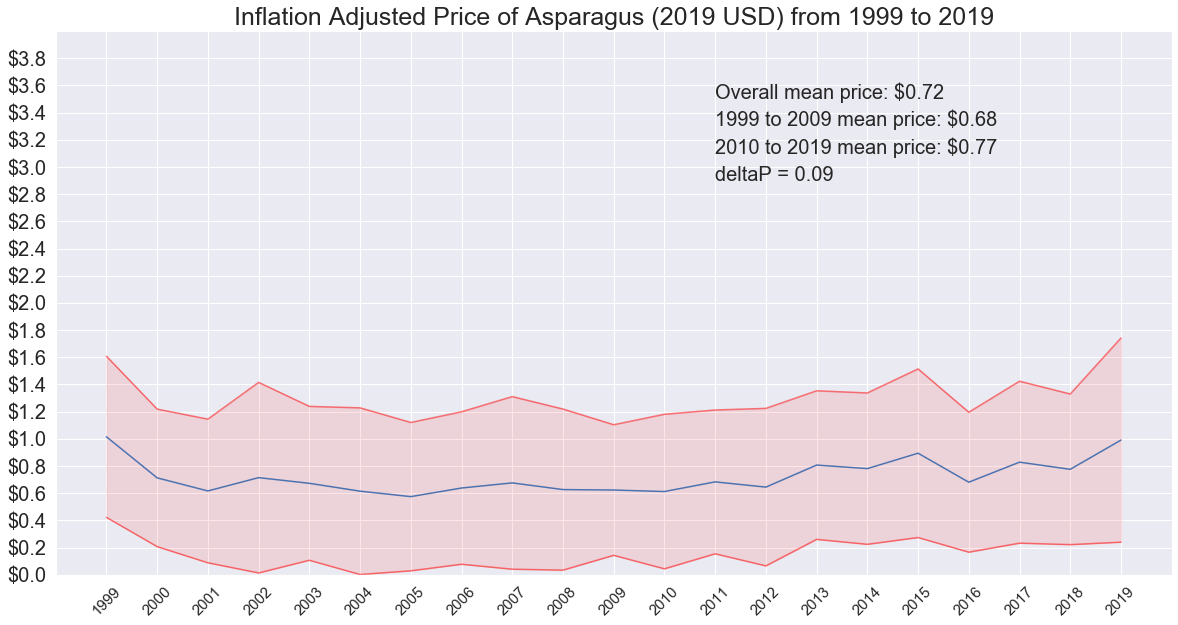

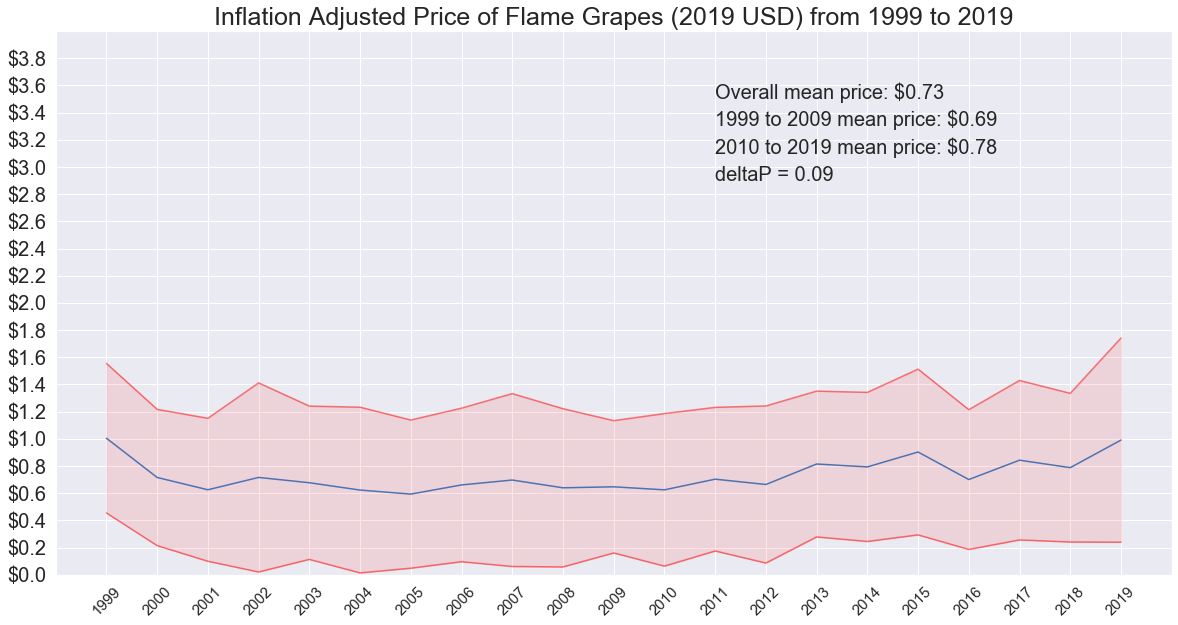

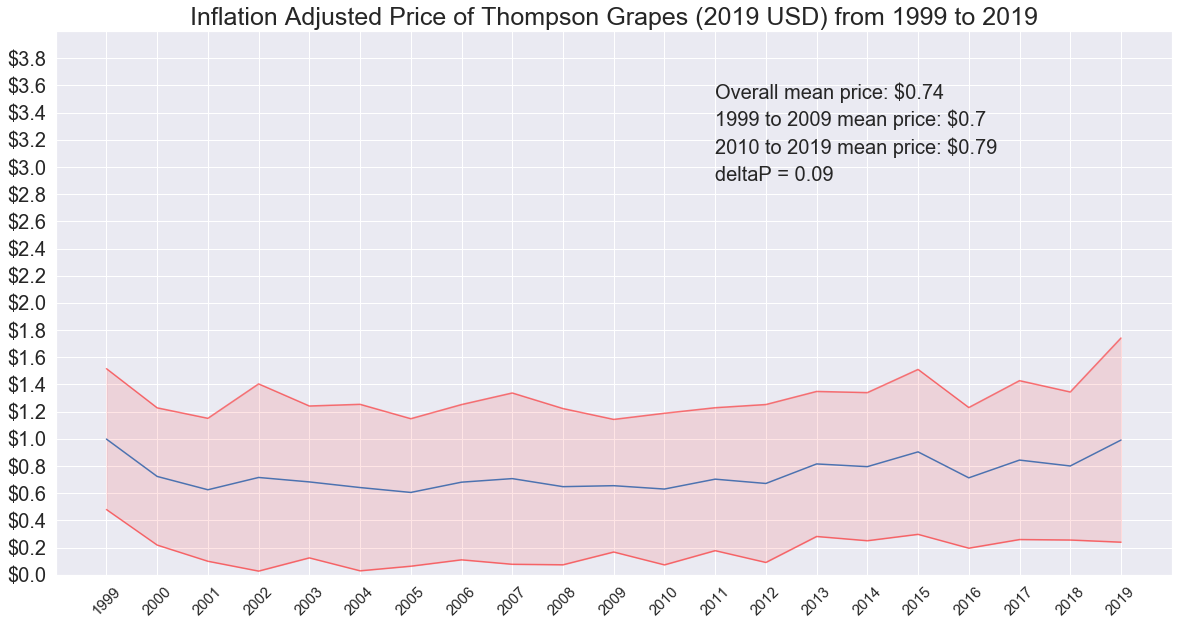

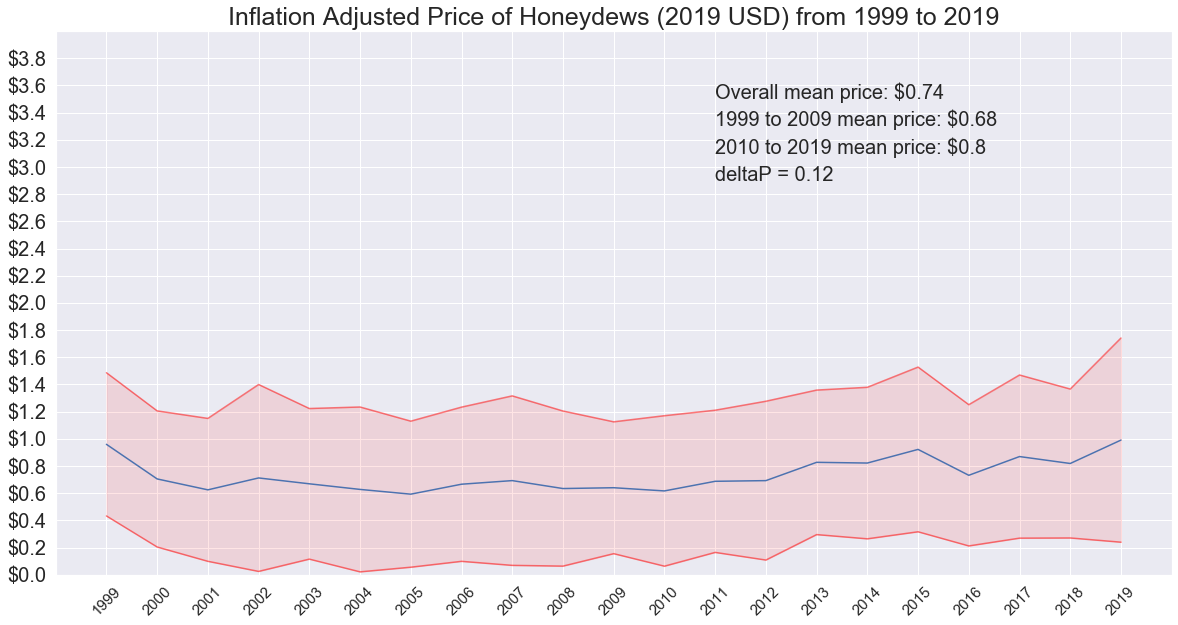

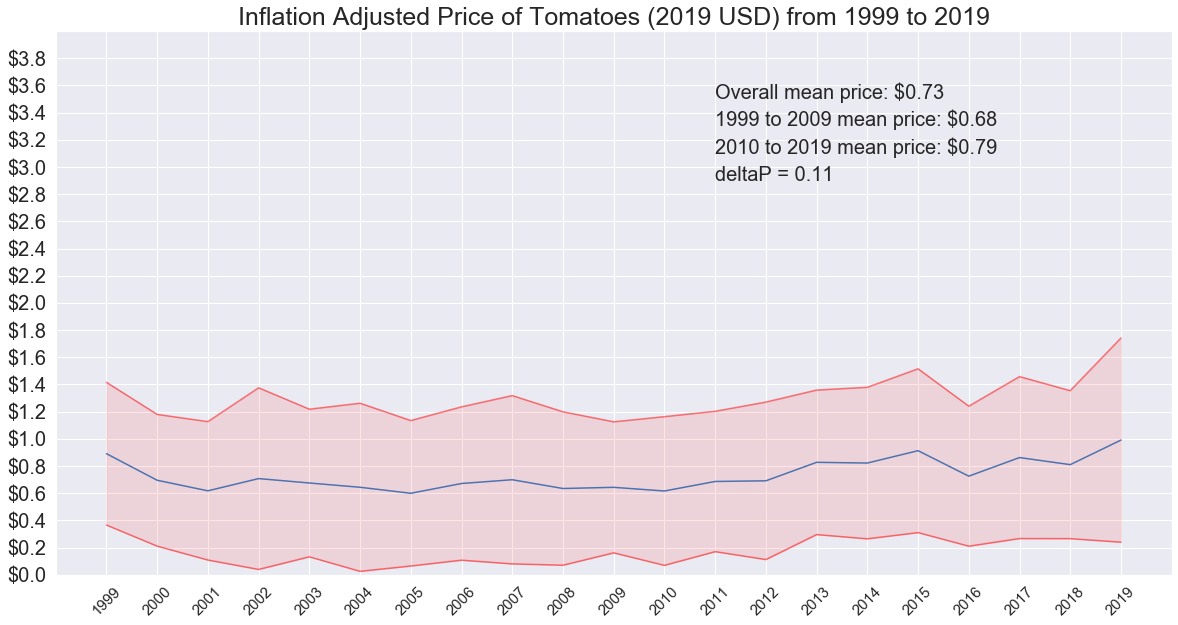

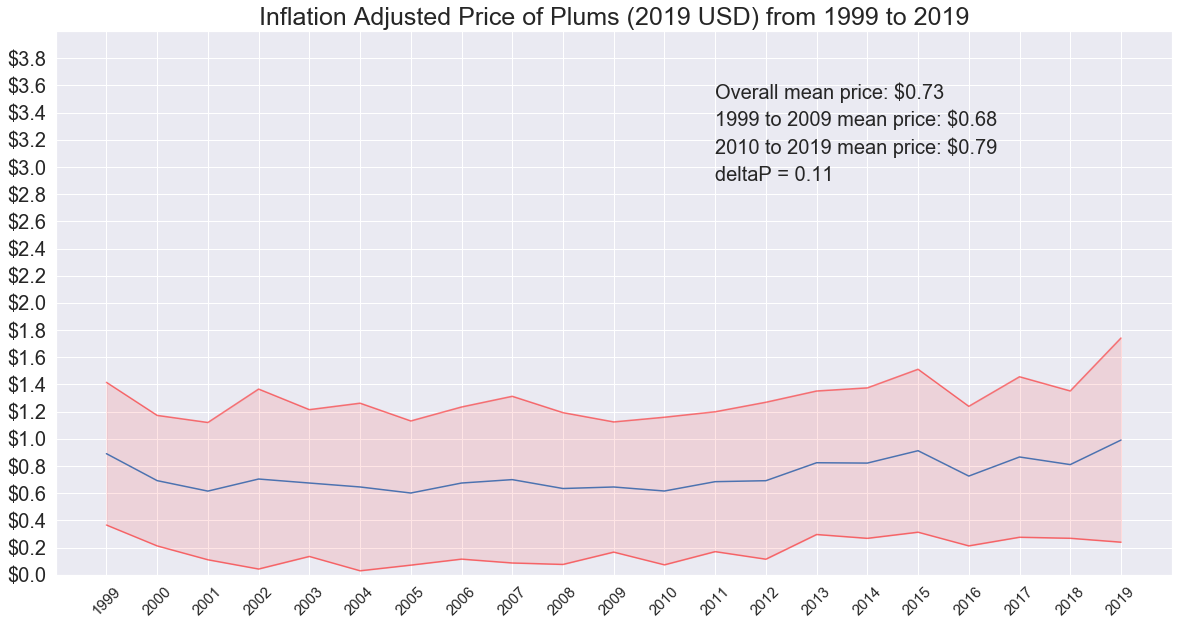

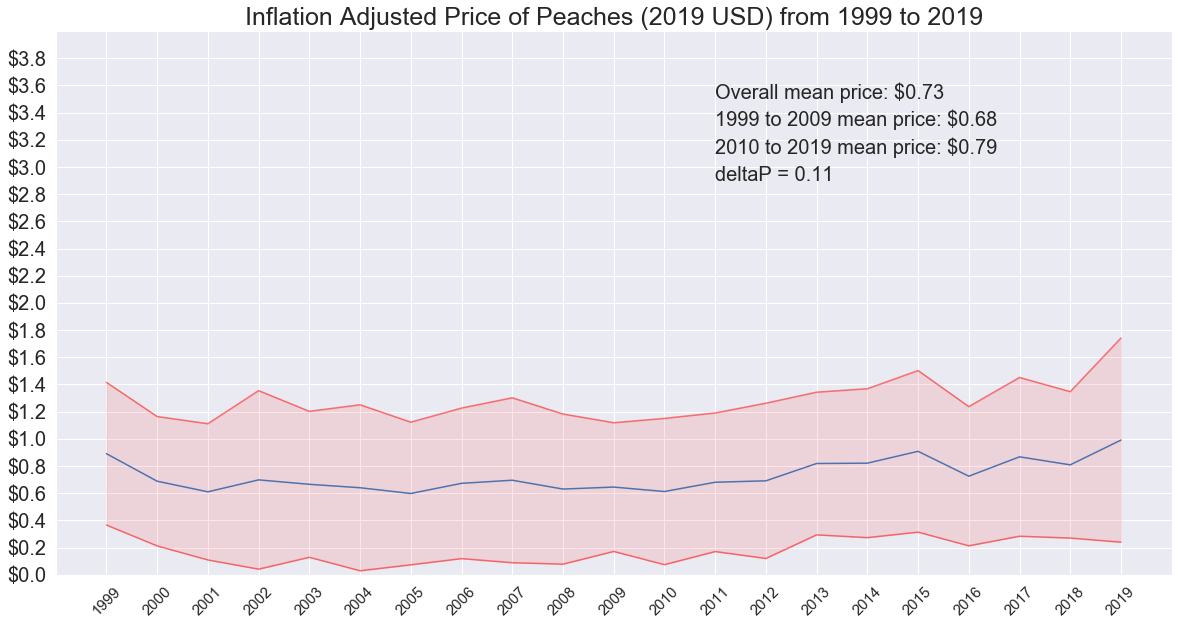

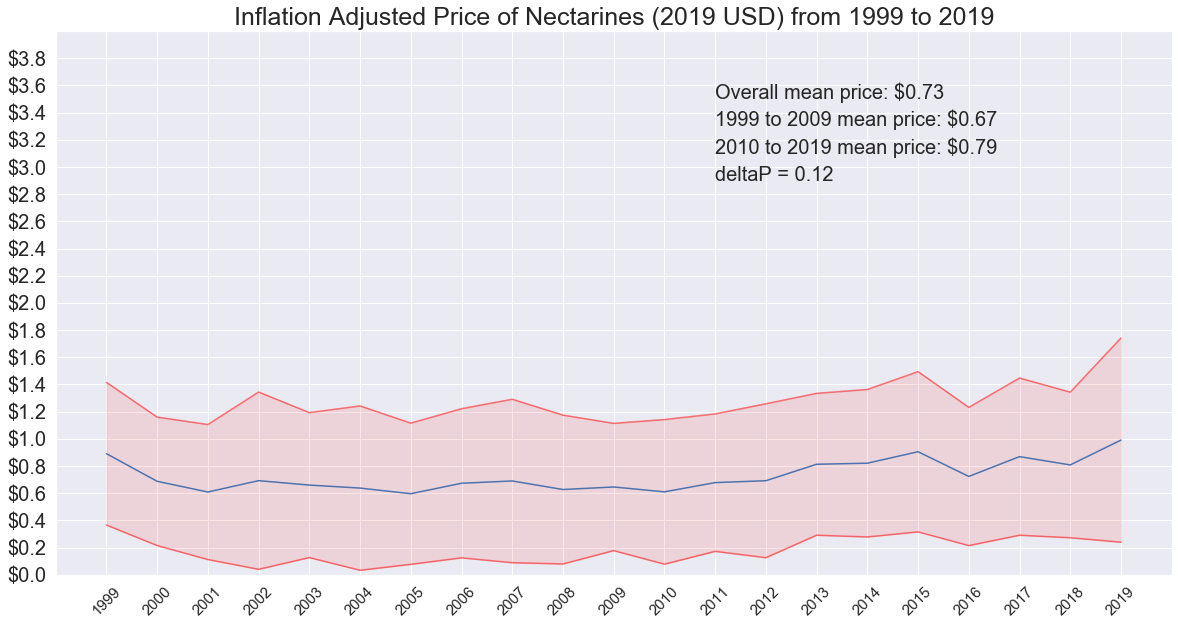

In [40]:
for item in produce_list:
    produce_plotter(item)
    


In [37]:
# Making a function for git
def git(text):
    '''Function adds, commits, and pushes to github. 
    Parameters: text; the message that is attached to the commit
    '''
    !git add .
    !git commit -m f'{text}'
    !git push origin master